In [24]:
import pandas as pd
import numpy as np

_m = pd.read_pickle('moonshot_submissions.p')



_m['covalent'] = _m[['Acrylamide',
                     'Acrylamide Adduct',
                     'Chloroacetamide',
                     'Chloroacetamide Adduct',
                     'Vinylsulfonamide',
                     'Vinylsulfonamide Adduct']].any(axis=1)  # not sure which is important

moonshot = _m.loc[_m.okay][['CID (canonical)','CID_group', 'old_index', 'clean_creator', 'SMILES', 'new_smiles',
                           'fragments', 'xcode', 'Structure ID', 'xcode','site_name', 'pdb_entry',
                            'ORDERED', 'MADE', 'ASSAYED', 'in_fragalysis',
                            'IC50', 'pIC50', 'prior', 'internal',
                           'submission_date', 'inferred_submission_date', 'order_date', 'shipment_date', 
                           'description', 'initial_screen',
                           'N_creator_submission', 'N_submission_group', 'resubmitted',
                           'Enamine - REAL Space', 'Enamine - Extended REAL Space',
                           'Enamine - SCR', 'Enamine - BB', 'Mcule', 'Mcule Ultimate',
                           'N_chars', 'N_words', 'N_words_cutoff', 'classified_method', 'flesch',
                           'dale_chall', 'covalent']]

del _m

moonshot['inferred_submission_month'] = moonshot.inferred_submission_date.apply(lambda d: d.month + 12 * (d.year -2020))
moonshot['pIC50'] = moonshot.IC50.apply(lambda i: -np.log10(i) + 6)
moonshot['category'] = moonshot.internal.map({True: 'Core', False: 'External'})
moonshot['short'] = moonshot.description.str.slice(0,50)

# for j, i in enumerate(moonshot.index[moonshot.initial_screen]):
#     moonshot.at[i, 'CID_group'] = f'DSi-poised-{j}'
    
moonshot['approach'] = moonshot.classified_method.map(dict(
                                    MANUAL_POSSIBLY='Unclear',
                                    DOCKING='Docking',
                                    MANUAL='Hypothesis-driven',
                                    FEP='FEP',
                                    PRIOR_SARS_INHIBITOR='Prior SARS inhibitor',
                                    STARTING_LIBRARY='Starting library',
                                   )
                              )

# double tap!
for k, v in moonshot.description.str.lower().str.replace(',','').str.contains('sars inhibitor').items():
    if v:
        moonshot.at[k, 'approach'] = 'Prior SARS inhibitor'

In [25]:
moonshot.approach.value_counts()

Unclear                 9285
Docking                 3116
Hypothesis-driven       1420
FEP                      161
Prior SARS inhibitor      44
Starting library          40
Name: approach, dtype: int64

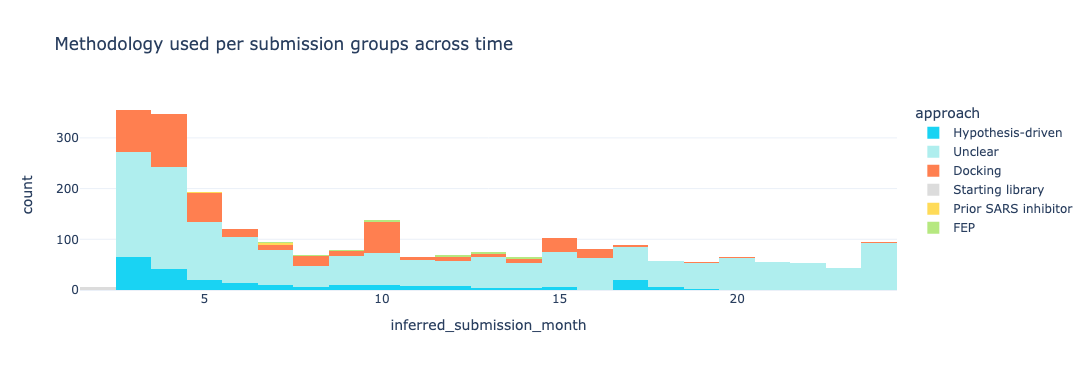

In [23]:
import plotly.express as px

fig = px.histogram(moonshot.drop_duplicates('CID_group'), 
                     'inferred_submission_month', 
                     color='approach',
                     color_discrete_map = {'Docking': '#ff7f50', 'Hypothesis-drivenL':'#30d5c8','Unclear': '#afeeee',
                                           'Prior SARS inhibitor':'#ffdb58','Starting library': 'gainsboro'},
                     title='Methodology used per submission groups across time',
                     template='plotly_white',
                    )
fig.write_image("images/methodology_time.svg", width=800, height=800, scale=2)
fig.write_image('images/methodology_time.jpg')
fig

In [ ]:
import plotly.express as px

fig = px.histogram(moonshot.loc[(moonshot.MADE)].drop_duplicates('CID_group'), 
                     'inferred_submission_month', 
                     color='approach',
                     color_discrete_map = {'Docking': '#ff7f50', 'Hypothesis-drivenL':'#30d5c8','Unclear': '#afeeee',
                                           'Prior SARS inhibitor':'#ffdb58','Starting library': 'gainsboro'},
                     title='Methodology used per _made_ submission groups across time',
                     template='plotly_white',
                    )
#fig.write_image("methodology_time.svg", width=800, height=800, scale=2)
fig

In [ ]:
import plotly.express as px
from datetime import datetime

date_cutoff = datetime(2021, 1, 1)
subbed = moonshot.loc[(moonshot.MADE) & (~moonshot.internal) & (moonshot.inferred_submission_date < date_cutoff)].drop_duplicates('CID_group')

fig = px.histogram(subbed, 
                     'inferred_submission_month', 
                     color='classified_method',
                     color_discrete_map = {'DOCKING': '#ff7f50', 'MANUAL':'#30d5c8','MANUAL_POSSIBLY': '#afeeee',
                                           'PRIOR_SARS_INHIBITOR':'#ffdb58','STARTING_LIBRARY': 'gainsboro'},
                     title=f'Methodology used per _made_ submission groups across time from not internal submitters (total: {len(subbed)}; submitted prior to {date_cutoff.strftime("%d-%m-%Y")})',
                     template='plotly_white',
                    )
#fig.write_image("methodology_time.svg", width=800, height=800, scale=2)
fig

In [ ]:
from datetime import datetime

date_cutoff = datetime(2020, 8, 1)

subbed = moonshot.loc[~moonshot.classified_method.isin(['STARTING_LIBRARY', 'UNKNOWN']) & \
                      (moonshot.submission_date < date_cutoff) & (moonshot.shipment_date < date_cutoff)
                     ]
fig = px.violin(subbed,
                title=f'pIC50 by approach taken used (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})',
                y='pIC50', x='approach',
               color='category',
                hover_data=['CID (canonical)', 'clean_creator', 'shipment_date', 'site_name', 'short'],
               box=True,
               points='all')
fig.update_traces(spanmode = 'hard')
fig.write_image("methodology_vio.jpg")
fig.write_image("methodology_vio.svg", width=800, height=800, scale=2)
fig

In [33]:
moonshot['ccategory'] = moonshot.internal.map({True: 'Core', False: 'Community'}) + moonshot.covalent.map({True: '_covalent', False: ''})

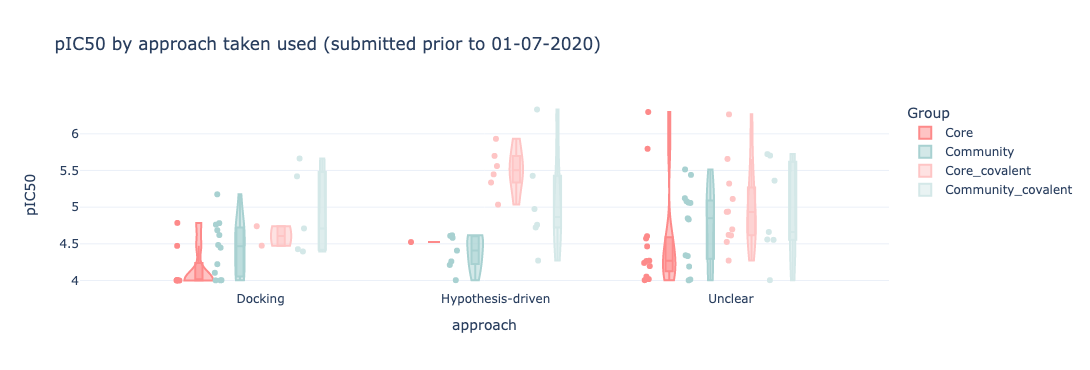

In [40]:
from datetime import datetime
import plotly.express as px

date_cutoff = datetime(2020, 7, 1)

subbed = moonshot.loc[~moonshot.classified_method.isin(['STARTING_LIBRARY', 'UNKNOWN']) & \
                      (moonshot.submission_date < date_cutoff) & (moonshot.shipment_date < date_cutoff) & \
                      (moonshot.approach != "Prior SARS inhibitor")
                     ]
fig = px.violin(subbed,
                title=f'pIC50 by approach taken used (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})',
                y='pIC50', x='approach',
               color='ccategory',
                template="plotly_white",
                hover_data=['CID (canonical)', 'clean_creator', 'shipment_date', 'site_name', 'short'],
               box=True,
               points='all',
               color_discrete_map={'Core': '#FD8A8A', 
                                   'Community': '#A8D1D1', 
                                   "Core_covalent": '#fec5c5',
                                   "Community_covalent": '#d4e8e8'
                                  },
               category_orders={"ccategory": ["Core", "Community", "Core_covalent", "Community_covalent"],
                              "approach": ["Docking", "Hypothesis-driven", "Unclear"],
                               }
               )
fig.update_traces(spanmode = 'hard')
fig.update_layout(legend=dict(title='Group'))
fig.write_image("images/methodology_covalent.png")
fig